# AI Geometry Tutor for Vietnamese High School Students

This notebook implements an AI-powered Geometry Tutor system using LangGraph and LLM-native reasoning. The system can:

- Parse Vietnamese geometry problems with multiple sequential questions
- Provide hints at different levels (conceptual, contextual, direct)
- Validate student solutions
- Generate complete step-by-step solutions
- Maintain state across multiple questions in a problem

## Architecture Overview

The system uses LangGraph to orchestrate a stateful workflow with specialized agents for different tasks:
- **Parsing Agent**: Extracts structured information from problem text
- **Solver Agent**: Develops solution paths using iterative reasoning
- **Hinting Agent**: Provides scaffolded hints based on solution path
- **Validation Agent**: Compares student solutions with correct reasoning
- **Solution Generation Agent**: Creates formatted final answers

## Dependencies and Setup

The system requires several key libraries for LLM integration and graph-based workflow management.

In [1]:
# Install required packages
# !pip install langgraph langchain langchain-google-genai python-dotenv typing-extensions

In [2]:
import os
import json
from typing import List, Dict, Any, Optional
from typing_extensions import TypedDict

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.state import CompiledStateGraph
from langchain_core.runnables import RunnableConfig

## Core Data Structures

The system uses a comprehensive state management approach with `GraphState` to track all aspects of the tutoring session.

In [3]:
class GraphState(TypedDict):
    """
    Core state object for the AI Geometry Tutor system.
    Manages all data throughout the problem-solving workflow.
    """

    # --- Initial Problem Setup ---
    original_problem: str  # Raw text input from the user
    parsed_elements: Dict[str, Any]  # Structured representation of geometric givens
    # Example: {'points': ['A', 'B'], 'lines': [], 'facts': ['AB=5']}
    questions: List[str]  # Ordered list of questions from the problem

    # --- Dynamic Solver State ---
    current_question_index: int  # The index of the current question being addressed
    known_facts: List[str]  # A running list of givens (initial facts from problem)
    ai_discovered_facts: List[
        str
    ]  # Facts discovered by AI during reasoning (separate from user knowledge)
    reasoning_chain: List[Dict[str, str]]  # The agent's step-by-step solution path
    # Example: [{'thought': '...', 'conclusion': '...'}]

    # --- User Interaction State ---
    user_solution_attempt: str  # The user's most recent solution submission
    hint_level: int  # Counter for hints requested (0-3)
    generated_hints: List[str]  # The text of hints already provided to the user
    is_validated: bool  # Flag indicating if the user's solution was marked correct

    # --- Output State ---
    final_answer: str  # The complete, formatted solution for the current question
    error_message: str  # For communicating errors (e.g., parsing failure)

    # --- Control Flow ---
    user_action: str  # Current user action: 'hint', 'validate', 'solve', 'start'
    session_complete: bool  # Flag indicating if all questions are complete


def create_initial_state(problem: str) -> GraphState:
    """Create an initial state object for a new problem."""
    return GraphState(
        original_problem=problem,
        parsed_elements={},
        questions=[],
        current_question_index=0,
        known_facts=[],
        ai_discovered_facts=[],
        reasoning_chain=[],
        user_solution_attempt="",
        hint_level=0,
        generated_hints=[],
        is_validated=False,
        final_answer="",
        error_message="",
        user_action="start",
        session_complete=False,
    )

## LLM Integration and Utilities

This section handles the Google Gemini LLM initialization and provides utility functions for JSON parsing and data formatting.

In [4]:
# Initialize the LLM
def initialize_llm():
    """Initialize the Google Gemini LLM with appropriate settings."""
    try:
        llm = ChatGoogleGenerativeAI(
            model="gemini-2.0-flash-exp",
            temperature=0.1,  # Low temperature for consistent reasoning
            max_output_tokens=2048,
        )
        return llm
    except Exception as e:
        print(f"Error initializing LLM: {e}")
        print("Please make sure you have set the GOOGLE_API_KEY environment variable")
        return None


# Helper functions for JSON parsing
def safe_json_parse(text: str, default: Optional[dict] = None) -> dict:
    """Safely parse JSON from LLM output, handling common formatting issues."""
    if default is None:
        default = {}

    try:
        # Try to find JSON in the text
        start_idx = text.find("{")
        end_idx = text.rfind("}") + 1

        if start_idx != -1 and end_idx != 0:
            json_str = text[start_idx:end_idx]
            return json.loads(json_str)
        else:
            return default
    except json.JSONDecodeError:
        return default


def format_facts_list(facts: List[str]) -> str:
    """Format a list of facts for display."""
    if not facts:
        return "Không có thông tin đã biết."
    return "\\n".join(f"- {fact}" for fact in facts)


def get_combined_facts(state: GraphState) -> List[str]:
    """
    Get combined facts for AI reasoning: known_facts + ai_discovered_facts.
    This is used internally by AI agents but not shown to user.
    """
    known = state.get("known_facts", [])
    ai_discovered = state.get("ai_discovered_facts", [])
    return known + ai_discovered

## Graph Nodes (AI Agents)

Each node represents a specialized AI agent responsible for specific aspects of the tutoring process.

In [5]:
def parse_problem(state: GraphState) -> GraphState:
    """
    Node 1: parse_problem
    Agent: "Parsing Agent"
    Extracts structured information from the Vietnamese geometry problem.
    """
    llm = initialize_llm()
    if not llm:
        state["error_message"] = (
            "Không thể khởi tạo mô hình AI. Vui lòng kiểm tra cấu hình API."
        )
        return state

    parsing_prompt = f"""
Bạn là một chuyên gia hình học. Hãy đọc bài toán sau và trích xuất tất cả thông tin hình học, 
các sự kiện đã cho, và các câu hỏi riêng biệt thành định dạng JSON.

Các câu hỏi phải được sắp xếp theo thứ tự tuần tự đúng.

Bài toán: {state['original_problem']}

Vui lòng trả về JSON với định dạng sau:
{{
    "points": ["A", "B", "C", ...],
    "lines": ["AB", "BC", ...],
    "shapes": ["triangle ABC", "circle O", ...],
    "given_facts": ["AB = 5", "góc ABC = 90°", ...],
    "questions": ["Chứng minh tam giác ABC vuông", "Tính diện tích tam giác", ...]
}}
"""

    try:
        response = llm.invoke(parsing_prompt)
        parsed_data = safe_json_parse(
            response.content,
            {
                "points": [],
                "lines": [],
                "shapes": [],
                "given_facts": [],
                "questions": [],
            },
        )

        state["parsed_elements"] = {
            "points": parsed_data.get("points", []),
            "lines": parsed_data.get("lines", []),
            "shapes": parsed_data.get("shapes", []),
            "facts": parsed_data.get("given_facts", []),
        }

        state["questions"] = parsed_data.get("questions", [])
        state["known_facts"] = parsed_data.get("given_facts", []).copy()

        if not state["questions"]:
            state["error_message"] = (
                "Không thể phân tích các câu hỏi từ bài toán. Vui lòng kiểm tra lại đề bài."
            )
        else:
            state["error_message"] = ""

    except Exception as e:
        state["error_message"] = f"Lỗi khi phân tích bài toán: {str(e)}"

    return state

### 1. Problem Parsing Agent

Extracts structured information from Vietnamese geometry problems and identifies individual questions.

In [6]:
def reason_and_solve(state: GraphState) -> GraphState:
    """
    Node 2: reason_and_solve
    Agent: "Solver Agent"
    Develops a step-by-step solution for the current question using iterative reasoning.
    AI discoveries are kept separate from user's known facts until solution is validated.
    """
    llm = initialize_llm()
    if not llm:
        state["error_message"] = "Không thể khởi tạo mô hình AI."
        return state

    if state["current_question_index"] >= len(state["questions"]):
        state["session_complete"] = True
        return state

    current_question = state["questions"][state["current_question_index"]]
    # Use only the base known facts (from problem) + any previously validated AI discoveries
    base_facts = state["known_facts"]
    ai_discoveries = []  # Fresh AI discoveries for this reasoning session
    reasoning_chain = []

    max_iterations = 10  # Prevent infinite loops
    iteration = 0

    while iteration < max_iterations:
        # Combine base facts with current AI discoveries for reasoning
        all_available_facts = base_facts + ai_discoveries

        solver_prompt = f"""
Bạn là một chuyên gia giải toán hình học. Mục tiêu của bạn là chứng minh/giải quyết: {current_question}

Bạn đã biết các sự kiện sau:
{format_facts_list(all_available_facts)}

Bước lập luận đã thực hiện:
{json.dumps(reasoning_chain, ensure_ascii=False, indent=2) if reasoning_chain else "Chưa có bước nào"}

Hãy xác định bước logic tiếp theo để đạt được mục tiêu. Trả về JSON với định dạng:
{{
    "thought": "Suy nghĩ logic cho bước này, bao gồm lập luận chi tiết",
    "conclusion": "Kết luận cụ thể từ bước này. Chỉ bao gồm kết luận cuối cùng, không cần lập luận",
    "is_goal_reached": true/false
}}

Nếu kết luận đã đạt được mục tiêu (trả lời được câu hỏi), hãy đặt is_goal_reached = true.
"""

        try:
            response = llm.invoke(solver_prompt)
            step_data = safe_json_parse(
                response.content,
                {
                    "thought": "Không thể phân tích bước này",
                    "conclusion": "",
                    "is_goal_reached": False,
                },
            )

            reasoning_chain.append(
                {
                    "thought": step_data.get("thought", ""),
                    "conclusion": step_data.get("conclusion", ""),
                }
            )

            # Add new conclusion to AI discoveries (separate from user's known facts)
            conclusion = step_data.get("conclusion", "").strip()
            if conclusion and conclusion not in all_available_facts:
                ai_discoveries.append(conclusion)

            # Check if goal is reached
            if (
                step_data.get("is_goal_reached", False)
                or iteration >= max_iterations - 1
            ):
                break

        except Exception as e:
            reasoning_chain.append(
                {
                    "thought": f"Lỗi trong quá trình lập luận: {str(e)}",
                    "conclusion": "Không thể tiếp tục lập luận",
                }
            )
            break

        iteration += 1

    # Store the reasoning chain and AI discoveries separately
    state["reasoning_chain"] = reasoning_chain
    state["ai_discovered_facts"] = ai_discoveries
    # known_facts remains unchanged - only contains original problem facts

    return state

### 2. Reasoning and Solving Agent

Develops step-by-step solutions using iterative reasoning while keeping AI discoveries separate from user knowledge.

In [7]:
def generate_hint(state: GraphState) -> GraphState:
    """
    Node 3: generate_hint
    Agent: "Hinting Agent"
    Provides scaffolded hints based on the AI's solution path.
    """
    llm = initialize_llm()
    if not llm:
        state["error_message"] = "Không thể khởi tạo mô hình AI."
        return state

    reasoning_chain = state["reasoning_chain"]
    hint_level = state["hint_level"]
    current_question = state["questions"][state["current_question_index"]]

    if hint_level >= 3:
        state["generated_hints"].append(
            "Bạn đã sử dụng hết số lần gợi ý. Hãy thử giải hoặc xem đáp án."
        )
        return state

    # Increment hint level
    state["hint_level"] = hint_level + 1
    new_hint_level = state["hint_level"]

    if new_hint_level == 1:
        # Hint 1: Conceptual - General strategy
        hint_prompt = f"""
Bạn là một giáo viên hình học. Học sinh đang giải câu hỏi: {current_question}

Các sự kiện học sinh đã biết:
{format_facts_list(state["known_facts"])}

Chuỗi lập luận đúng là:
{json.dumps(reasoning_chain, ensure_ascii=False, indent=2)}

Hãy đưa ra gợi ý khái niệm tổng quát (không tiết lộ chi tiết cụ thể) về chiến lược giải quyết. 
Đặt câu hỏi hướng dẫn để học sinh tự suy nghĩ.
"""

    elif new_hint_level == 2:
        # Hint 2: Contextual - Point to specific facts
        # Use only user's known facts for hints, not AI discoveries
        hint_prompt = f"""
Bạn là một giáo viên hình học. Học sinh đang giải câu hỏi: {current_question}

Các sự kiện học sinh đã biết:
{format_facts_list(state["known_facts"])}

Chuỗi lập luận đúng:
{json.dumps(reasoning_chain, ensure_ascii=False, indent=2)}

Hãy chỉ ra những sự kiện cụ thể từ danh sách đã biết mà học sinh cần chú ý để thực hiện bước tiếp theo.
Không tiết lộ bước lập luận, chỉ hướng dẫn tập trung vào thông tin nào.
"""

    else:  # hint_level == 3
        # Hint 3: Direct - Next step suggestion
        hint_prompt = f"""
Bạn là một giáo viên hình học. Học sinh đang giải câu hỏi: {current_question}

Các sự kiện học sinh đã biết:
{format_facts_list(state["known_facts"])}

Chuỗi lập luận đúng:
{json.dumps(reasoning_chain, ensure_ascii=False, indent=2)}

Hãy gợi ý trực tiếp bước tiếp theo mà học sinh nên thực hiện, nhưng vẫn để học sinh tự hoàn thành.
Đưa ra một gợi ý cụ thể dưới dạng đề xuất.
"""

    try:
        response = llm.invoke(hint_prompt)
        hint_text = response.content.strip()
        state["generated_hints"].append(hint_text)

        # Display the generated hint immediately
        print("\n" + "=" * 60)
        print(f"💡 GỢI Ý LẦN {new_hint_level}")
        print("=" * 60)
        print(hint_text)
        print("=" * 60 + "\n")

    except Exception as e:
        error_message = f"Lỗi khi tạo gợi ý: {str(e)}"
        state["generated_hints"].append(error_message)
        print(f"❌ {error_message}")

    return state

### 3. Hinting Agent

Provides scaffolded hints at three levels: conceptual, contextual, and direct guidance.

In [8]:
def validate_solution(state: GraphState) -> GraphState:
    """
    Node 4: validate_solution
    Agent: "Validation Agent"
    Compares student solution with the correct reasoning path.
    """
    llm = initialize_llm()
    if not llm:
        state["error_message"] = "Không thể khởi tạo mô hình AI."
        return state

    user_solution = state["user_solution_attempt"]
    reasoning_chain = state["reasoning_chain"]
    current_question = state["questions"][state["current_question_index"]]

    validation_prompt = f"""
Bạn là một trợ giảng dạy hình học. Một chuỗi lập luận đúng là:

{json.dumps(reasoning_chain, ensure_ascii=False, indent=2)}

Học sinh đã nộp lời giải sau cho câu hỏi "{current_question}":

{user_solution}

Hãy so sánh lập luận của học sinh với đường lối giải đúng. Lập luận của học sinh có hợp lý không?

Nếu đúng, hãy khen ngợi và xác nhận. Nếu sai, hãy nhẹ nhàng giải thích điểm sai hoặc những gì học sinh còn thiếu.

Trả về JSON với định dạng:
{{
    "is_correct": true/false,
    "feedback": "Phản hồi chi tiết cho học sinh",
    "score": 0-100
}}
"""

    try:
        response = llm.invoke(validation_prompt)
        validation_data = safe_json_parse(
            response.content,
            {
                "is_correct": False,
                "feedback": "Không thể đánh giá lời giải",
                "score": 0,
            },
        )

        state["is_validated"] = validation_data.get("is_correct", False)

        # Store validation feedback
        feedback = validation_data.get("feedback", "Không có phản hồi")
        score = validation_data.get("score", 0)

        state["final_answer"] = (
            f"**Kết quả đánh giá:**\\n{feedback}\\n\\n**Điểm: {score}/100**"
        )

        if state["is_validated"]:
            state["final_answer"] += "\\n\\n✅ Lời giải của bạn đã được chấp nhận!"

            # MERGE AI discoveries into known facts when solution is validated
            ai_discoveries = state.get("ai_discovered_facts", [])
            current_known = state["known_facts"]

            # Add AI discoveries to known facts (avoid duplicates)
            for discovery in ai_discoveries:
                if discovery and discovery not in current_known:
                    current_known.append(discovery)

            state["known_facts"] = current_known
            # Clear AI discoveries since they're now part of known facts
            state["ai_discovered_facts"] = []

    except Exception as e:
        state["final_answer"] = f"Lỗi khi đánh giá lời giải: {str(e)}"
        state["is_validated"] = False

    return state

### 4. Validation Agent

Compares student solutions with the correct reasoning path and provides detailed feedback.

In [9]:
def generate_solution(state: GraphState) -> GraphState:
    """
    Node 5: generate_solution
    Agent: "Solution Generation Agent"
    Transforms the structured reasoning into a formatted final answer.
    """
    llm = initialize_llm()
    if not llm:
        state["error_message"] = "Không thể khởi tạo mô hình AI."
        return state

    reasoning_chain = state["reasoning_chain"]
    current_question = state["questions"][state["current_question_index"]]

    solution_prompt = f"""
Bạn là một giáo viên hình học. Hãy viết một lời giải rõ ràng, từng bước dựa trên chuỗi logic sau.
Giải thích mỗi bước một cách rõ ràng bằng tiếng Việt.

Câu hỏi: {current_question}

Chuỗi lập luận:
{json.dumps(reasoning_chain, ensure_ascii=False, indent=2)}

Hãy viết lời giải hoàn chỉnh với định dạng:
- Đầu tiên nêu rõ điều cần chứng minh/tính toán
- Từng bước giải thích chi tiết
- Kết luận cuối cùng

Sử dụng định dạng Markdown để làm đẹp lời giải.
"""

    try:
        response = llm.invoke(solution_prompt)
        state["final_answer"] = response.content.strip()

        # Display the generated solution immediately
        print("\n" + "=" * 60)
        print("📖 LỜI GIẢI HOÀN CHỈNH")
        print("=" * 60)
        print(state["final_answer"])
        print("=" * 60 + "\n")

        # MERGE AI discoveries into known facts when complete solution is provided
        ai_discoveries = state.get("ai_discovered_facts", [])
        current_known = state["known_facts"]

        # Add AI discoveries to known facts (avoid duplicates)
        for discovery in ai_discoveries:
            if discovery and discovery not in current_known:
                current_known.append(discovery)

        state["known_facts"] = current_known
        # Clear AI discoveries since they're now part of known facts
        state["ai_discovered_facts"] = []

    except Exception as e:
        state["final_answer"] = f"Lỗi khi tạo lời giải: {str(e)}"
        print(f"❌ {state['final_answer']}")

    return state


def move_to_next_question(state: GraphState) -> GraphState:
    """
    Node 6: move_to_next_question
    Standard function to advance to the next question and reset interaction state.
    """
    # Increment question index
    state["current_question_index"] += 1

    # Reset interaction-specific state
    state["hint_level"] = 0
    state["generated_hints"] = []
    state["is_validated"] = False
    state["user_solution_attempt"] = ""
    state["final_answer"] = ""
    state["reasoning_chain"] = []
    state["ai_discovered_facts"] = []  # Reset AI discoveries for new question

    # Check if all questions are complete
    if state["current_question_index"] >= len(state["questions"]):
        state["session_complete"] = True
        completion_message = (
            "🎉 **Chúc mừng!** Bạn đã hoàn thành tất cả câu hỏi trong bài toán này!"
        )
        state["final_answer"] = completion_message

        # Display completion message immediately
        print("\n" + "=" * 60)
        print("🎉 HOÀN THÀNH BÀI TOÁN")
        print("=" * 60)
        print(completion_message)
        print("=" * 60 + "\n")

    # known_facts persists across questions
    return state

### 5. Prompting for Input Agent

In [10]:
def await_user_action(state: GraphState) -> GraphState:
    """
    Active node that handles user input directly within the graph flow.
    Displays current question and prompts for user action.
    """

    def display_question_and_status(state: GraphState) -> None:
        """Display the current question and available user actions."""
        current_question_index = state.get("current_question_index", 0)
        questions = state.get("questions", [])

        if current_question_index >= len(questions):
            print("🎉 Đã hoàn thành tất cả câu hỏi!")
            return

        current_question = questions[current_question_index]
        hint_level = state.get("hint_level", 0)
        generated_hints = state.get("generated_hints", [])

        print("=" * 60)
        print(f"📋 CÂU HỎI {current_question_index + 1}/{len(questions)}")
        print("=" * 60)
        print(f"❓ {current_question}")
        print()

        # Show current status - only user's known facts
        if state.get("known_facts"):
            print("📝 Các sự kiện đã biết:")
            for i, fact in enumerate(state["known_facts"], 1):
                print(f"  {i}. {fact}")
            print()

        # Show hints if any have been generated
        if generated_hints:
            print("💡 Gợi ý đã nhận:")
            for i, hint in enumerate(generated_hints, 1):
                print(f"\n📌 Gợi ý {i}:")
                print(f"  {hint}")
            print()

        # Show available actions
        print("🎯 Các hành động có thể thực hiện:")
        print("  1. 💡 Xin gợi ý (hint)")
        print("  2. 📝 Nộp lời giải (submit)")
        print("  3. 📖 Xem đáp án (solution)")
        if state.get("is_validated"):
            print("  4. ➡️  Câu hỏi tiếp theo (next)")
        print("  5. 📊 Xem trạng thái (status)")
        print("  6. 🚪 Thoát (exit)")
        print()

    def get_user_input_in_node() -> str:
        """Get user input for the current action within the graph node."""
        try:
            user_choice = input("👤 Chọn hành động (1-6): ").strip()
            return user_choice
        except KeyboardInterrupt:
            print("\n👋 Thoát chương trình...")
            return "6"  # Exit
        except Exception as e:
            print(f"❌ Lỗi: {e}")
            return ""

    current_question_index = state.get("current_question_index", 0)
    questions = state.get("questions", [])

    if current_question_index >= len(questions):
        state["session_complete"] = True
        return state

    # Display current question and status
    display_question_and_status(state)

    # Get user input directly
    user_choice = get_user_input_in_node()

    # Store user choice in state for routing
    state["user_action"] = user_choice

    return state

## Graph Routing and User Interaction

This section handles the workflow logic, user input processing, and graph construction for the LangGraph-based system.

In [11]:
def route_user_action(state: GraphState) -> str:
    def display_detailed_status(state: GraphState) -> str:
        """Display detailed status information."""
        current_question_index = state.get("current_question_index", 0)
        questions = state.get("questions", [])
        hint_level = state.get("hint_level", 0)

        print("📊 TRẠNG THÁI CHI TIẾT:")
        print(f"  📍 Câu hỏi: {current_question_index + 1}/{len(questions)}")
        print(f"  💡 Gợi ý đã dùng: {hint_level}/3")
        print(f"  ✅ Đã xác thực: {'Có' if state.get('is_validated') else 'Chưa'}")
        if current_question_index < len(questions):
            print(f"  🎯 Câu hỏi: {questions[current_question_index]}")
        print()
        # Default fallback - this should handle cases where user_action is unexpected
        return "await_user_action"

    """
    Routing function to determine the next node based on user action and state.
    """

    if state.get("error_message"):
        return END

    if state.get("session_complete"):
        return END

    user_action = state.get("user_action", "")

    # Initial routing after problem parsing
    if user_action == "start":
        return "reason_and_solve"

    # Route based on user's chosen action from input
    elif user_action == "1" or user_action.lower() == "hint":
        # Check if user has reached hint limit
        hint_level = state.get("hint_level", 0)
        if hint_level >= 3:
            print("⚠️  Bạn đã sử dụng hết 3 gợi ý cho câu hỏi này!")
            return "await_user_action"
        return "generate_hint"

    elif user_action == "2" or user_action.lower() == "submit":
        # Get user's solution input
        try:
            print("📝 Nhập lời giải của bạn:")
            solution = input("👤 Lời giải: ").strip()
            if solution:
                state["user_solution_attempt"] = solution
                return "validate_solution"
            else:
                print("❌ Lời giải không được để trống!")
                return "await_user_action"
        except Exception as e:
            print(f"❌ Lỗi khi nhập lời giải: {e}")
            return "await_user_action"

    elif user_action == "3" or user_action.lower() == "solution":
        return "generate_solution"

    elif user_action == "4" or user_action.lower() == "next":
        if state.get("is_validated"):
            return "move_to_next_question"
        else:
            print("❌ Cần hoàn thành câu hỏi hiện tại trước khi chuyển tiếp!")
            return "await_user_action"
    elif user_action == "5" or user_action.lower() == "status":
        # Display status and return to user input
        display_detailed_status(state)
        return "await_user_action"

    elif user_action == "6" or user_action.lower() == "exit":
        print("👋 Cảm ơn bạn đã sử dụng AI Geometry Tutor!")
        state["session_complete"] = True
        return END

    # Legacy routing for backward compatibility

    elif user_action == "hint":
        return "generate_hint"

    elif user_action == "validate":
        return "validate_solution"

    elif user_action == "solve":
        return "generate_solution"

    elif user_action == "next":
        return "move_to_next_question"

    else:
        if user_action:  # Only show error for non-empty input
            print("❌ Lựa chọn không hợp lệ! Vui lòng chọn từ 1-6.")
        return "await_user_action"


def should_continue_after_validation(state: GraphState) -> str:
    """
    Routing function after validation to determine if we should move to next question.
    """
    # Display the validation feedback
    if state.get("final_answer"):
        print("\n" + "=" * 60)
        print("📝 KẾT QUẢ ĐÁNH GIÁ")
        print("=" * 60)
        print(state["final_answer"])
        print("=" * 60 + "\n")

    if state.get("is_validated"):
        print("✅ Lời giải của bạn đã được xác nhận!")
        return "move_to_next_question"

    else:
        print("❌ Lời giải của bạn không chính xác. Vui lòng thử lại hoặc xin gợi ý.")
        return "await_user_action"


def should_continue_after_next_question(state: GraphState) -> str:
    """
    Routing function after moving to next question.
    """

    if state.get("session_complete"):
        return END
    else:
        return "reason_and_solve"


def create_geometry_tutor_graph() -> CompiledStateGraph:
    """
    Creates and compiles the LangGraph workflow for the Geometry Tutor.
    """

    # Create the graph
    workflow = StateGraph(GraphState)

    # Add nodes
    workflow.add_node("parse_problem", parse_problem)
    workflow.add_node("reason_and_solve", reason_and_solve)
    workflow.add_node("generate_hint", generate_hint)
    workflow.add_node("validate_solution", validate_solution)
    workflow.add_node("generate_solution", generate_solution)
    workflow.add_node("move_to_next_question", move_to_next_question)
    workflow.add_node("await_user_action", await_user_action)

    # Set entry point
    workflow.set_entry_point("parse_problem")

    # Add edges
    workflow.add_conditional_edges(
        "parse_problem",
        route_user_action,
        {
            "reason_and_solve": "reason_and_solve",
            "await_user_action": "await_user_action",
            END: END,
        },
    )
    workflow.add_edge("reason_and_solve", "await_user_action")
    workflow.add_conditional_edges(
        "await_user_action",
        route_user_action,
        {
            "generate_hint": "generate_hint",
            "validate_solution": "validate_solution",
            "generate_solution": "generate_solution",
            "move_to_next_question": "move_to_next_question",
            "await_user_action": "await_user_action",
            END: END,
        },
    )
    workflow.add_edge("generate_hint", "await_user_action")
    workflow.add_conditional_edges(
        "validate_solution",
        should_continue_after_validation,
        {
            "move_to_next_question": "move_to_next_question",
            "await_user_action": "await_user_action",
        },
    )
    workflow.add_edge("generate_solution", "move_to_next_question")
    workflow.add_conditional_edges(
        "move_to_next_question",
        should_continue_after_next_question,
        {"reason_and_solve": "reason_and_solve", END: END},
    )

    # Compile the graph
    return workflow.compile()

## Main Tutor Class

The `GeometryTutor` class provides a clean, high-level interface for interacting with the LangGraph workflow.

In [12]:
class GeometryTutor:
    """
    Main class for the AI Geometry Tutor system.
    Provides a clean interface for interacting with the LangGraph workflow.
    """

    def __init__(self):
        self.graph = create_geometry_tutor_graph()
        self.current_state = None  # type: ignore
        self.thread_id = None

    def start_new_problem(self, problem_text: str) -> Dict[str, Any]:
        """
        Start a new geometry problem session with integrated interactive mode.
        This method now automatically runs the interactive session within the graph flow.

        Args:
            problem_text: The Vietnamese geometry problem text

        Returns:
            Dictionary with session completion status
        """
        # Create initial state
        initial_state = create_initial_state(problem_text)

        # Generate a unique thread ID for this session
        import time

        self.thread_id = f"geometry_session_{int(time.time())}"

        # Run the complete interactive session within the graph
        config = RunnableConfig({"configurable": {"thread_id": self.thread_id}})

        try:
            print("🚀 Bắt đầu phiên học AI Geometry Tutor")
            print("=" * 60)

            # Set initial action to start the session
            initial_state["user_action"] = "start"

            # Execute the graph with the new interactive flow
            for state in self.graph.stream(initial_state, config):
                self.current_state: dict = list(state.values())[0]

                # # Break if session is complete or error occurred
                # if self.current_state.get("session_complete") or self.current_state.get(
                #     "error_message"
                # ):
                #     break

            if self.current_state.get("error_message"):
                return {"success": False, "error": self.current_state["error_message"]}

            return {
                "success": True,
                "session_complete": self.current_state.get("session_complete", False),
                "total_questions": len(self.current_state.get("questions", [])),
                "message": "Phiên học đã hoàn thành thành công!",
            }

        except Exception as e:
            return {"success": False, "error": f"Lỗi trong phiên học: {str(e)}"}

    def get_current_status(self) -> Dict[str, Any]:
        """Get the current status of the tutoring session."""
        if not self.current_state:
            return {"success": False, "error": "Chưa có bài toán nào được khởi tạo"}

        return {
            "success": True,
            "current_question_index": self.current_state["current_question_index"] + 1,
            "total_questions": len(self.current_state["questions"]),
            "current_question": (
                self.current_state["questions"][
                    self.current_state["current_question_index"]
                ]
                if self.current_state["current_question_index"]
                < len(self.current_state["questions"])
                else ""
            ),
            "hint_level": self.current_state["hint_level"],
            "hints_used": len(self.current_state["generated_hints"]),
            "is_validated": self.current_state["is_validated"],
            "session_complete": self.current_state["session_complete"],
            "known_facts": self.current_state["known_facts"],
        }


print("GeometryTutor class implemented successfully!")

GeometryTutor class implemented successfully!


## Graph Visualization

Visual representation of the LangGraph workflow showing the connections between different AI agents.

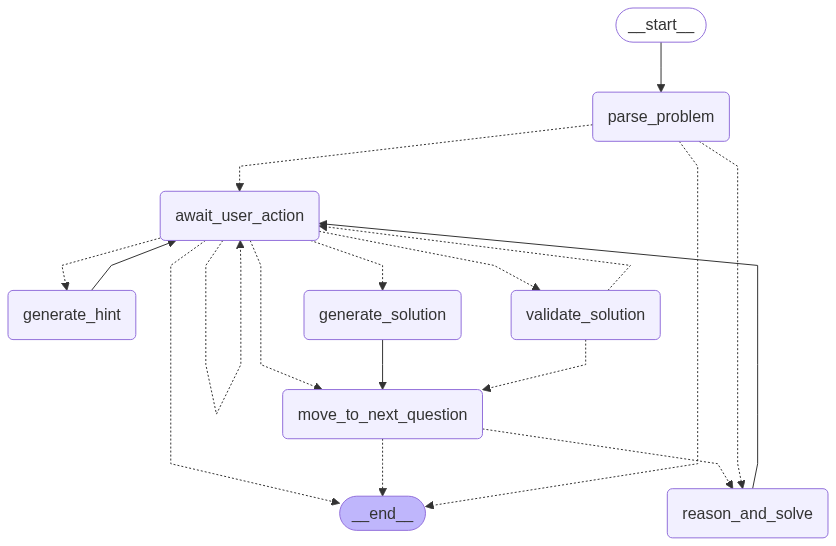

In [13]:
from IPython.display import Image, display

display(Image(GeometryTutor().graph.get_graph().draw_mermaid_png()))

## Demo and Usage Example

Interactive demonstration of the AI Geometry Tutor system with a sample Vietnamese geometry problem.

In [14]:
def demo_geometry_tutor():
    """
    Hàm demo cho hệ thống AI Geometry Tutor
    """

    # Khởi tạo tutor
    tutor = GeometryTutor()

    # Bài toán mẫu
    sample_problem = """
    Cho tam giác ABC có AB = 6 cm, BC = 8 cm, CA = 10 cm.
    a) Chứng minh tam giác ABC là tam giác vuông.
    b) Tính diện tích tam giác ABC.
    c) Tính độ dài đường cao từ đỉnh B xuống cạnh AC.
    """

    print("🚀 Demo AI Geometry Tutor")
    print("=" * 50)
    print(f"Bài toán: {sample_problem}")
    print("=" * 50)

    # Bước 1: Khởi tạo bài toán
    print("📋 BƯỚC 1: Phân tích bài toán...")
    result = tutor.start_new_problem(sample_problem)

    # Bước 2: Kiểm tra trạng thái
    print("📊 BƯỚC 2: Trạng thái hiện tại...")
    status = tutor.get_current_status()

    if status["success"]:
        print(
            f"📍 Câu hỏi: {min(status['current_question_index'], status['total_questions'])}/{status['total_questions']}"
        )
        print(f"✅ Đã xác thực: {status['is_validated']}")
        print(f"🏁 Hoàn thành: {status['session_complete']}")

    print("🎉 Demo hoàn thành!")


demo_geometry_tutor()

🚀 Demo AI Geometry Tutor
Bài toán: 
    Cho tam giác ABC có AB = 6 cm, BC = 8 cm, CA = 10 cm.
    a) Chứng minh tam giác ABC là tam giác vuông.
    b) Tính diện tích tam giác ABC.
    c) Tính độ dài đường cao từ đỉnh B xuống cạnh AC.
    
📋 BƯỚC 1: Phân tích bài toán...
🚀 Bắt đầu phiên học AI Geometry Tutor
📋 CÂU HỎI 1/3
❓ Chứng minh tam giác ABC là tam giác vuông.

📝 Các sự kiện đã biết:
  1. AB = 6 cm
  2. BC = 8 cm
  3. CA = 10 cm

🎯 Các hành động có thể thực hiện:
  1. 💡 Xin gợi ý (hint)
  2. 📝 Nộp lời giải (submit)
  3. 📖 Xem đáp án (solution)
  5. 📊 Xem trạng thái (status)
  6. 🚪 Thoát (exit)

📋 CÂU HỎI 1/3
❓ Chứng minh tam giác ABC là tam giác vuông.

📝 Các sự kiện đã biết:
  1. AB = 6 cm
  2. BC = 8 cm
  3. CA = 10 cm

🎯 Các hành động có thể thực hiện:
  1. 💡 Xin gợi ý (hint)
  2. 📝 Nộp lời giải (submit)
  3. 📖 Xem đáp án (solution)
  5. 📊 Xem trạng thái (status)
  6. 🚪 Thoát (exit)


💡 GỢI Ý LẦN 1
Tuyệt vời! Em đang đi đúng hướng để chứng minh tam giác ABC là tam giác vuông.

